In [1]:
from tensorflow import keras
model = keras.models.load_model("3-conv-32-layer-1-dense.model_00h")
model.summary()

Model: "my_functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 30, 12)]      0         
                                                                 
 sequential (Sequential)     (None, 30, 30, 12)        0         
                                                                 
 my_conv2d_1 (Conv2D)        (None, 28, 28, 32)        3488      
                                                                 
 my_pooling_1 (MaxPooling2D)  (None, 14, 14, 32)       0         
                                                                 
 my_conv2d_2 (Conv2D)        (None, 12, 12, 64)        18496     
                                                                 
 my_pooling_2 (MaxPooling2D)  (None, 6, 6, 64)         0         
                                                                 
 my_conv2d_3 (Conv2D)        (None, 4, 4, 128) 

In [2]:
#
# Function to return input data as an numpy array
#
def prepare(filepath):
    IMG_SIZE = 30
    number_channels = 12
    f = netCDF4.Dataset(filepath)
    abv = f.variables['absvprs']
    nx = np.size(abv[0,0,:])
    ny = np.size(abv[0,:,0])
    nz = np.size(abv[:,0,0])
    #print('Dimension of input NETCDF is: ',nx,ny,nz)
    a2 = np.zeros((nx,ny,number_channels))
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,0] = abv[1,j,i]    # abs vort at 950 mb
    rel = f.variables['rhprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,1] = rel[7,j,i]    # RH at 750 mb
    sfc = f.variables['pressfc']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,2] = sfc[j,i]      # surface pressure
    tmp = f.variables['tmpprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,3] = tmp[15,j,i]   # temperature at 400 mb
    tsf = f.variables['tmpsfc']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,4] = tsf[j,i]      # surface temperature
    ugr = f.variables['ugrdprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,5] = ugr[3,j,i]    # u-wind at 900 mb
            a2[i,j,6] = ugr[17,j,i]   # u-wind at 300 mb
    vgr = f.variables['vgrdprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,7] = vgr[3,j,i]    # v-wind at 900 mb
            a2[i,j,8] = vgr[17,j,i]   # v-wind at 300 mb
    hgt = f.variables['hgtprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,9] = hgt[3,j,i]    # geopotential at 850 mb
    wgr = f.variables['vvelprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,10] = wgr[3,j,i]   # w-wind at 900 mb
            a2[i,j,11] = wgr[17,j,i]  # w-wind at 300 mb
    new_array = cv2.resize(a2, (IMG_SIZE, IMG_SIZE))
    #
    # normalize the data
    #
    #print('Number of channels to normalize is: ',number_channels)
    for var in range(number_channels):
        maxvalue = new_array[:,:,var].flat[np.abs(new_array[:,:,var]).argmax()]
        #print('Normalization factor for channel',var,', is: ',abs(maxvalue))
        new_array[:,:,var] = new_array[:,:,var]/abs(maxvalue)
    out_array = np.reshape(new_array, (-1, IMG_SIZE, IMG_SIZE, number_channels))
    #print('reshape new_array returns: ',out_array.shape)
    #input('Enter to continue...')
    return out_array

In [3]:
#
# reading a sample input file for visualizing the activation map 
#
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import netCDF4
import numpy as np
DATADIR = "/N/project/hurricane-deep-learning/data/ncep_extracted_binary_30x30/ncep_WP_binary_0h/pos/"
infile = DATADIR + '/20210715_18_00_16.6_135.1_2021197N17135.nc'
print("File to process is: ",infile)
indata = prepare(infile)
print("Input data shape is: ",indata.shape)

File to process is:  /N/project/hurricane-deep-learning/data/ncep_extracted_binary_30x30/ncep_WP_binary_0h/pos//20210715_18_00_16.6_135.1_2021197N17135.nc
Input data shape is:  (1, 30, 30, 12)


In [4]:
#
# extract layers information from the model 
#
from tensorflow.keras import layers
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer,(layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs) 
activations = activation_model.predict(indata)
for i in range(len(layer_names)):
    print(layer_outputs[i],"-----",layer_names[i]) 

1/1 [==============================] - 1s 720ms/step
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 32), dtype=tf.float32, name=None), name='my_conv2d_1/Relu:0', description="created by layer 'my_conv2d_1'") ----- my_conv2d_1
KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 32), dtype=tf.float32, name=None), name='my_pooling_1/MaxPool:0', description="created by layer 'my_pooling_1'") ----- my_pooling_1
KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 64), dtype=tf.float32, name=None), name='my_conv2d_2/Relu:0', description="created by layer 'my_conv2d_2'") ----- my_conv2d_2
KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 64), dtype=tf.float32, name=None), name='my_pooling_2/MaxPool:0', description="created by layer 'my_pooling_2'") ----- my_pooling_2
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 128), dtype=tf.float32, name=None), name='my_conv2d_3/Relu:0', description="created by layer 'my_conv2d_3'") ----- my_conv2d_3
KerasTensor(type_spec=TensorSpec(shape

6
(1, 28, 28, 32)


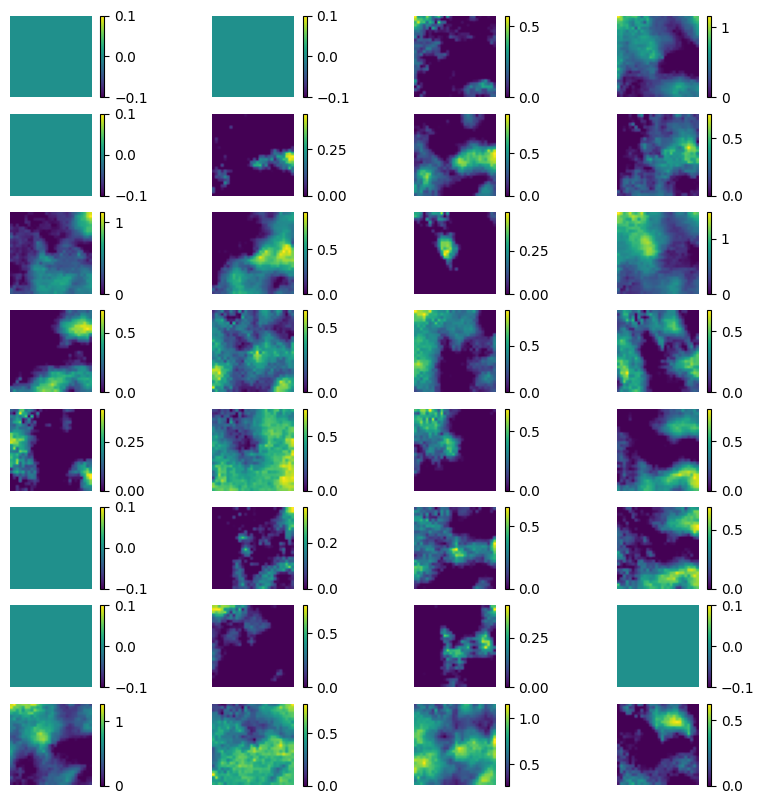

In [12]:
#
# display the first activation layer with 32 channels
#
import matplotlib.pyplot as plt
print(len(activations))
first_layer = activations[0]
print(first_layer.shape)
plt.figure(figsize=(10,10))
for i in range(32):
    ax = plt.subplot(8,4,i+1)
    plt.imshow(first_layer[0,:,:,i],cmap="viridis")
    #plt.contourf(first_layer[0,:,:,i],cmap="viridis")
    plt.colorbar()
    plt.axis("off")    

my_conv2d_1 (1, 28, 28, 32) 32 28 2 (58, 464)
my_pooling_1 (1, 14, 14, 32) 32 14 2 (30, 240)
my_conv2d_2 (1, 12, 12, 64) 64 12 4 (52, 208)
my_pooling_2 (1, 6, 6, 64) 64 6 4 (28, 112)
my_conv2d_3 (1, 4, 4, 128) 128 4 8 (40, 80)
my_pooling_3 (1, 2, 2, 128) 128 2 8 (24, 48)


/tmp/ipykernel_128293/3438278740.py:30: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(display_grid, aspect="auto", cmap="viridis")


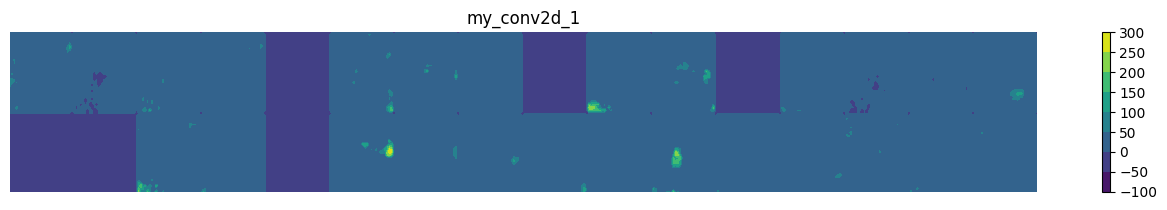

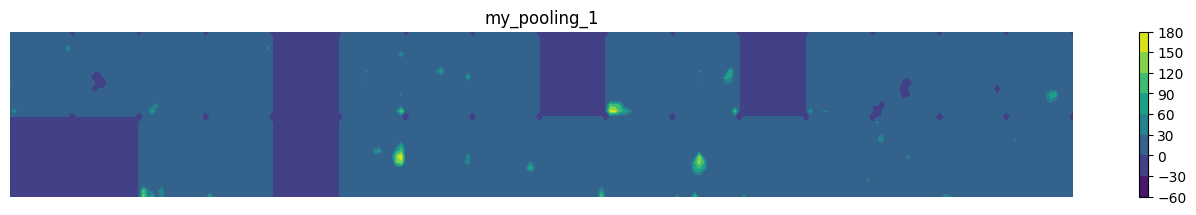

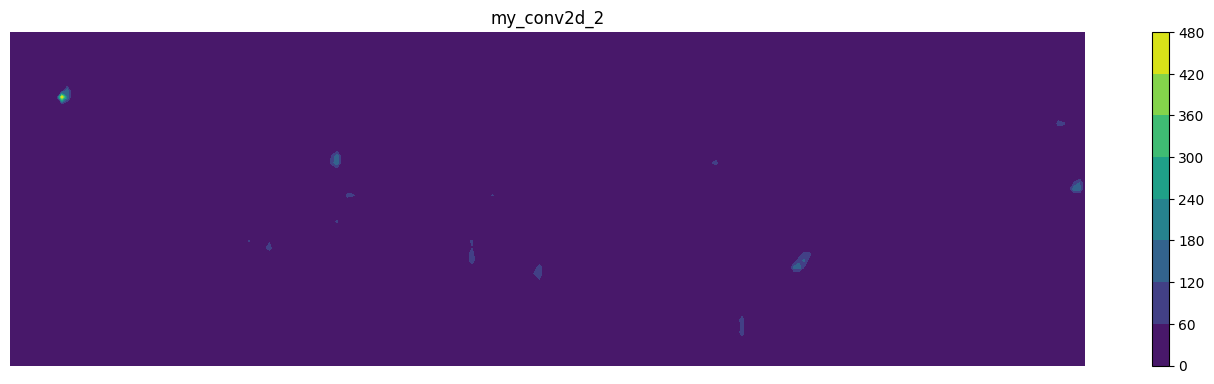

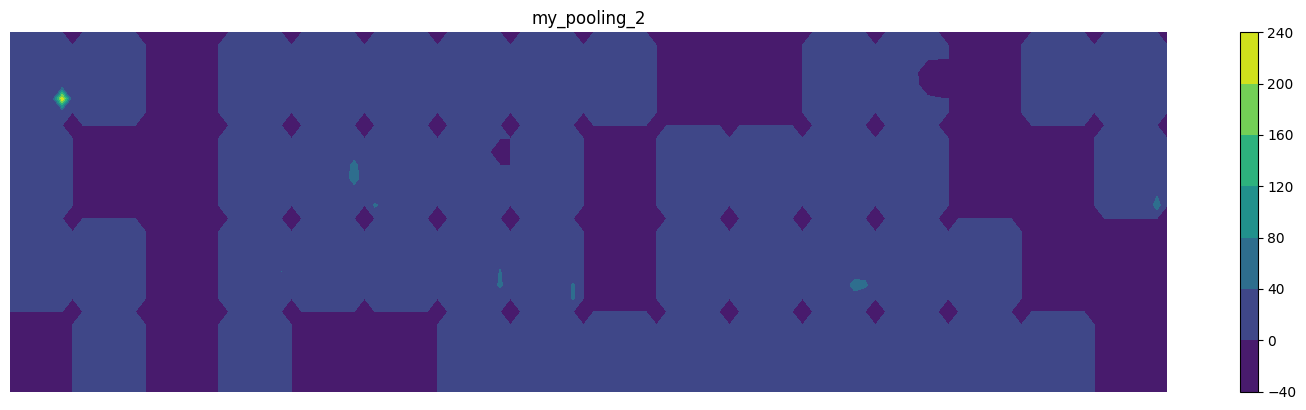

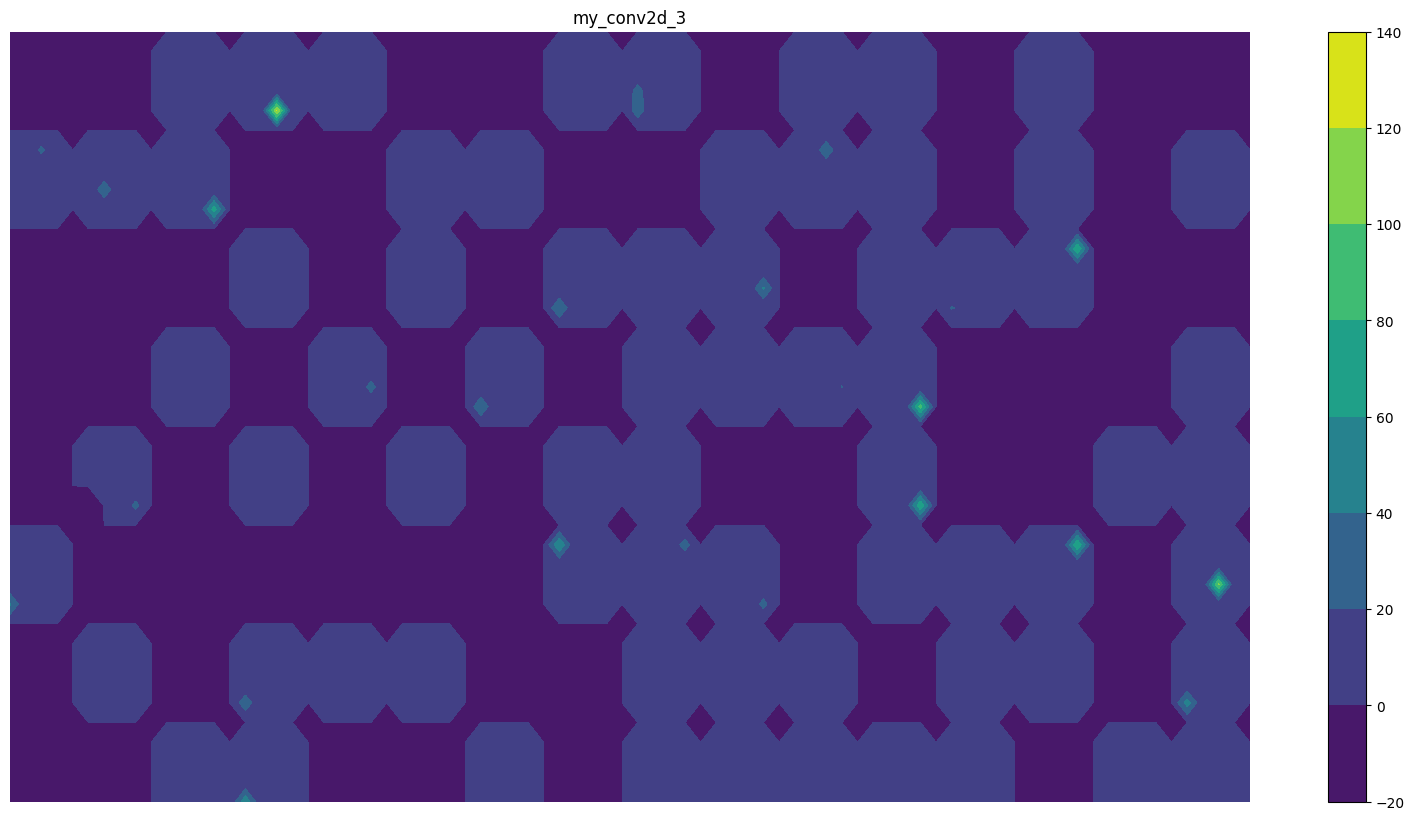

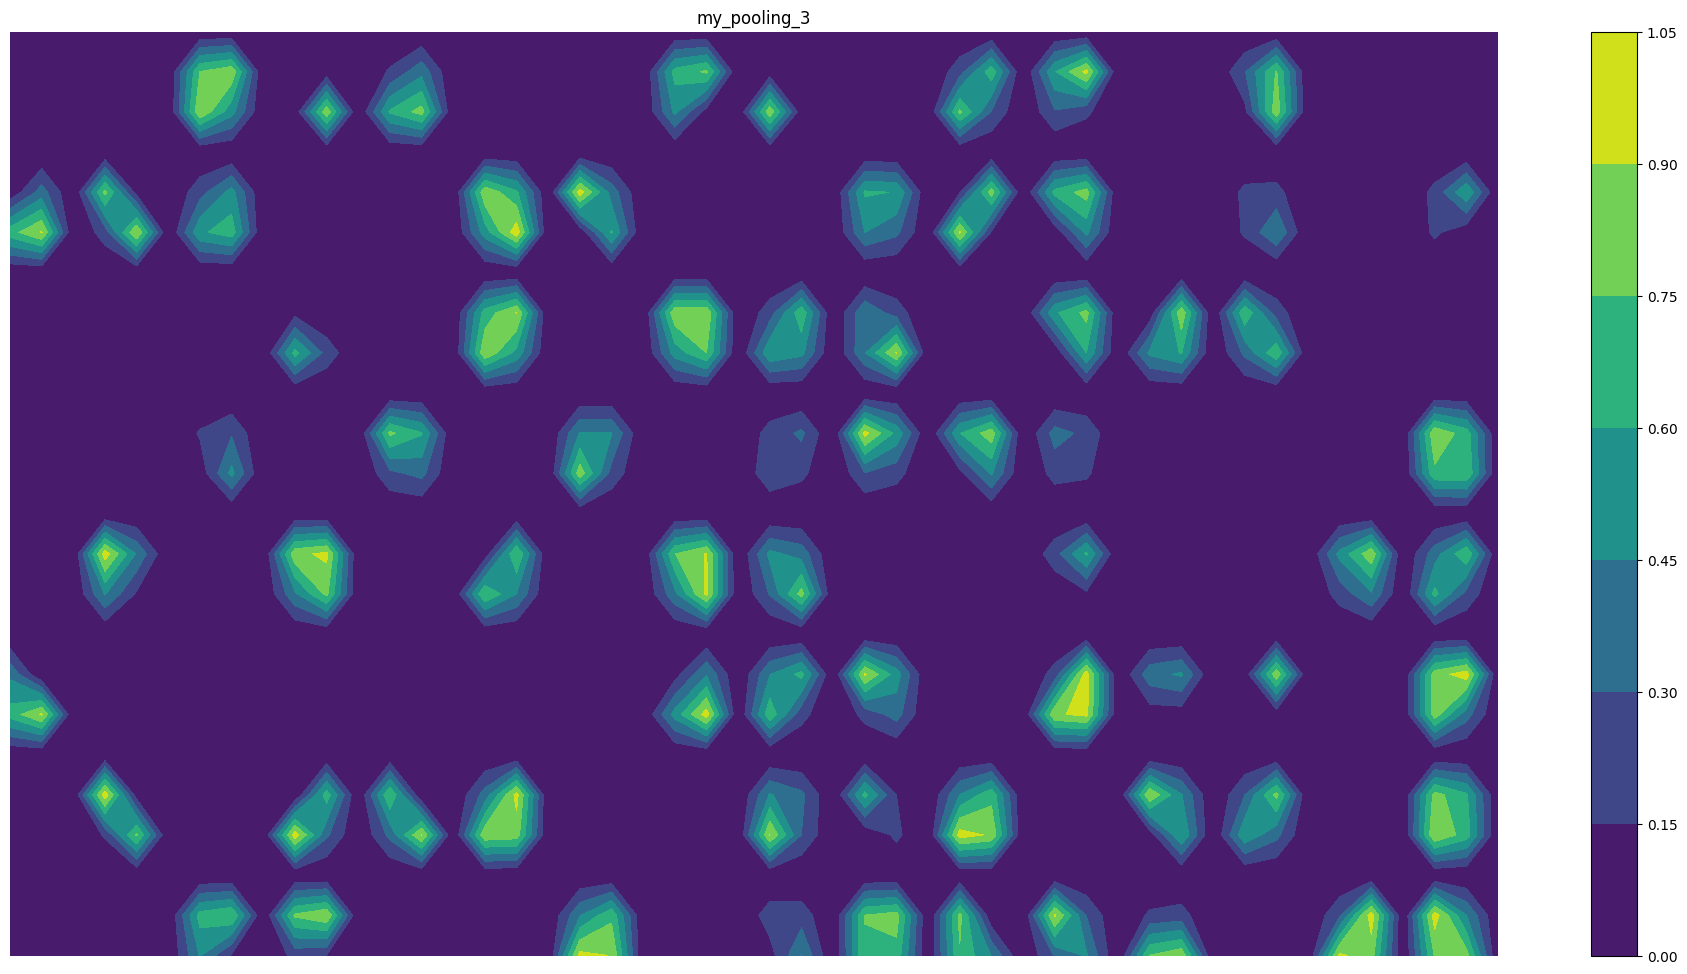

In [25]:
#
# more fancy display of all activation layers and channels
#
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size+1)*n_cols, images_per_row*(size+1)))
    print(layer_name,layer_activation.shape,n_features,size,n_cols,display_grid.shape)
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col*images_per_row + row
            channel_image = layer_activation[0,:,:,channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image -= np.clip(channel_image,0 ,255).astype("uint8")
            display_grid[col*(size+1):(col+1)*size+col,row*(size+1):(row+1)*size+row] = channel_image
     
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],scale*display_grid.shape[0]))
    #plt.figure(figsize=(16,2))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")    
    plt.contourf(display_grid, aspect="auto", cmap="viridis")
    plt.colorbar()
    #break